<a href="https://colab.research.google.com/github/rishabhm4/Densenet---Keras/blob/master/Denset%20testing%20with%20hyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Section I**
--- 
## Implementation of DenseNet using tf.keras functional API

> This section implements the state of the art DenseNet architecture and applies the same on CIFAR10 data. for simplicity pupose we are not following the exact same architecture rather a shorter version of the same. We also havn't use Batch Normalization layers or Drop out layers, as the functionality of these layers has not been covered by the course yet. Also we have modified the kernel size of some pooling layers considering the relatively öow 32x32 resolution of the dataset.

> The goal of this notebook is not to achieve very high accuracy as we are not implementing DenseNet architecture to its entirety, but to analyze the impact of experiments with different hyper-parameter.

>  We tried to implement the architecture in a moduler way, each reusable block is a function. we will further perform some experiments in order to increase accuracy. we have used some tricks showed in the original dense net paper.

In [0]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, Activation, Input, AveragePooling2D, Concatenate, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

* Importing CIFAR 10 data set from keras and assigning the same in training and test
* Preparinga Augmented dataset as well for experiment 
* Normalizing the train and test images 

In [0]:
cifar10_dataset = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10_dataset.load_data()

#For Augmented training.
train_images_aug=train_images.repeat(3,0)
train_labels_aug=train_labels.repeat(3,0)

In [0]:
train_images = train_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255
#train_images = train_images + np.random.normal(0, 0.2)
test_images = test_images.reshape([-1, 32,32, 3]).astype(np.float32) / 255
train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)

# For augmented training
train_images_aug = train_images_aug.reshape([-1, 32, 32, 3]).astype(np.float32) / 255
train_labels_aug = train_labels_aug.astype(np.int32)

### Plotting the first 25 training image from the dataset. 

* This set is a collection of heterogeneous 10 classes. 
* The dataset contain RGB images and they are of share 32*32. Along with a depth of 3.
* Images belong to following classes --> "Airplane","Automobile","Bird","Cat","Deer","Dog","Frog","Horse","Ship","Truck"

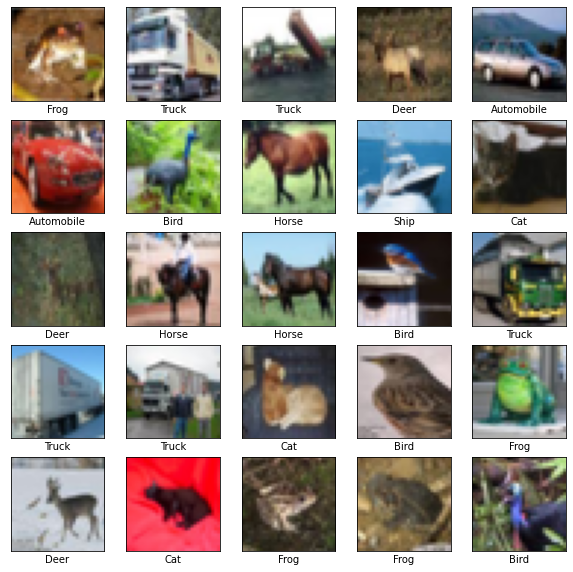

In [0]:
classes = ["Airplane","Automobile","Bird","Cat","Deer","Dog","Frog","Horse","Ship","Truck"]
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(classes[int(train_labels[i])])
plt.show()

The following method implements the functionality of a single dense block. 
* Number of layer in the dense block, filter size of the laver and the growth of each layer is parameterized.
* each layer correspond to Relu -> 1x1 Conv -> Relu -> Con2D opeations
* same padding is used to keep the feature map size same and to dacilitate concatenation.

In [0]:
def denseBlock( depth, inp, k_size= 3, growth= 12 ):
  act_layer = Activation('relu')
  ip = inp
  for layer in range(1, depth+1):
    op = act_layer(ip)
    op = Conv2D(growth*4, 1, padding="same")(op)
    op = act_layer(op)
    op = Conv2D(growth, k_size, padding="same")(op)
    ip = concatenate([ip, op])
  return ip    


The following method implements the combination of 1 translation layer(Dimensionaly reduction) + 1 dense block. Total number of repeation of such combination is controlled by a for loop along with passed parameters.

In [0]:
def extenDenseBlock(depth, k_size, inp, dense_depth,theta = 1, growth= 12):
  ip = inp
  for layers in range (1, depth +1):
    op = denseBlock( dense_depth[layers -1],ip, k_size,growth )
    op = Activation('relu')(op)
    op = Conv2D(op.shape[-1]*theta, 1, padding="same")(op)
    op = AveragePooling2D(pool_size=(2, 2))(op)
    ip = op
  return ip;   


This function returns the main maodel based on the provided parameters. This method also contain layers, that cant be used a repeated blocks, like Input layer, first conv2d and max pool blocks. and finally returns the complte model.

In [0]:
def denseModel(input_shape, f_size, init_depth, trans_block_depth, theta, dense_depth, growth, dense_block_f, final_dense_depth):
  x_inp = Input(input_shape)
  x = Conv2D(init_depth, f_size, padding = "same", use_bias=False)(x_inp)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = extenDenseBlock(trans_block_depth, dense_block_f,  x, dense_depth,theta,growth)
  x = denseBlock(dense_block_f, x,final_dense_depth, growth)
  x = AveragePooling2D(pool_size=(2, 2), strides=(1,1))(x)
  x = Flatten()(x)
  x = Dense(10, activation = 'softmax')(x)
  
  # Create model
  myDensemodel = Model(inputs = x_inp, outputs = x, name='DenseNetModel')
  return myDensemodel

## **Experiment 1:**
> #### Changing the depth of dense blocks 
we will be testing following configurations [3,3,3], [3,6,6], [6,6,6],[6,12,12],[6,12,24]. So total of 5 rounds of training and testing are performed as part of this experiment. 

> Other parameters are--
+ Bottleneck Theta = 1
* Growth = 12
* filter size in dense block = 2
* Final dense block depth  = 12
* Number of total dense blocks = 4

> As mentioned in the DenseNet paper we used SGD optimizer for our training. Training will be done using batch size 64 and epoch = 60. We will start at learning rate 0.01 and momentum = 0.8 

Dense layer depths:  [3, 3, 3]
Training accuray : 87.08, and validation accuracy :75.24
Final test accuracy :  72.85
Dense layer depths:  [3, 6, 6]
Training accuray : 90.7, and validation accuracy :67.7
Final test accuracy :  67.19
Dense layer depths:  [6, 6, 6]
Training accuray : 91.69, and validation accuracy :73.12
Final test accuracy :  72.03
Dense layer depths:  [6, 12, 12]
Training accuray : 95.96, and validation accuracy :75.92
Final test accuracy :  74.75
Dense layer depths:  [6, 12, 24]
Training accuray : 96.8, and validation accuracy :73.36
Final test accuracy :  71.55


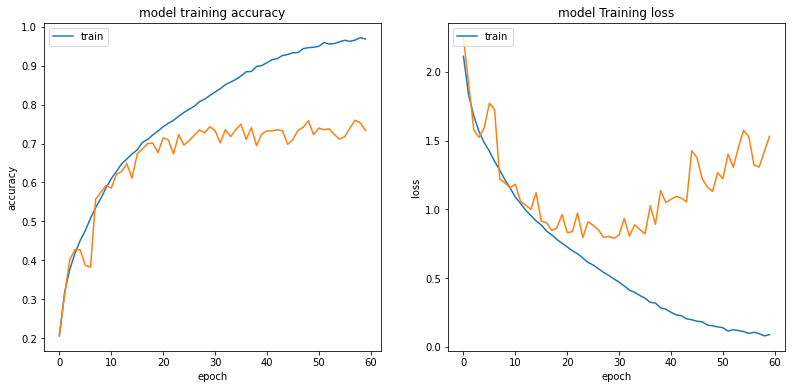

In [0]:
for dense_layers in [[3,3,3], [3,6,6], [6,6,6],[6,12,12],[6,12,24]]:
  print("Dense layer depths: ", dense_layers)
  mydenseModel = denseModel((32, 32, 3), 5,64,3,1,dense_layers, 12, 2,12)
  mydenseModel.compile(optimizer=tf.optimizers.SGD( learning_rate=0.01, momentum=0.8),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
  history = mydenseModel.fit(train_images, train_labels,batch_size=64, epochs=60, validation_split = 0.1 , verbose=0)
  print("Training accuray : {}, and validation accuracy :{}".format(round(history.history["accuracy"][-1]*100,2),round(history.history["val_accuracy"][-1]*100,2)))
  test_loss, test_acc = mydenseModel.evaluate(test_images,  test_labels, verbose=0)
  print('Final test accuracy : ', round(test_acc*100,2))

# summarize history for final run of the experiment
plt.figure(figsize=(35,35))
plt.subplot(5,5,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.subplot(5,5,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## Observations:
* Without any normalization layer, drop out layer or regularization, there is certainly overfitting in the network. The plots above corroborate the fact. From the loss plot, we can see that after some time the validation loss going up again where as the training loss going sharply down
* Dense layers with more number of layer produce more over fitting.
* Best outcome(In terms of test accuracy) is with config : [6,12,12]

## **Experiment 2:**
> #### Changing the growth rate od the network
we will be testing following configurations 6,12,24,36 for network growth. So total of 4 rounds of training and testing are performed as part of this experiment. 

> Other parameters are--
* Bottleneck Theta = 1
* Depth of dense blocks = [6,12,12] (Experiment 1 outcome)
* filter size in dense block = 2
* Final dense block depth  = 12
* Number of total dense blocks = 4
* Here we are using only 40 epochs to remedy over fitting

Growth rate is :  6
Training accuray : 83, and validation accuracy :68
313/313 - 2s - loss: 1.1365 - accuracy: 0.6686
Final test accuracy :  67
Growth rate is :  12
Training accuray : 89, and validation accuracy :75
313/313 - 2s - loss: 0.9633 - accuracy: 0.7301
Final test accuracy :  73
Growth rate is :  24
Training accuray : 93, and validation accuracy :75
313/313 - 3s - loss: 1.0334 - accuracy: 0.7413
Final test accuracy :  74
Growth rate is :  36
Training accuray : 95, and validation accuracy :76
313/313 - 5s - loss: 1.1173 - accuracy: 0.7413
Final test accuracy :  74


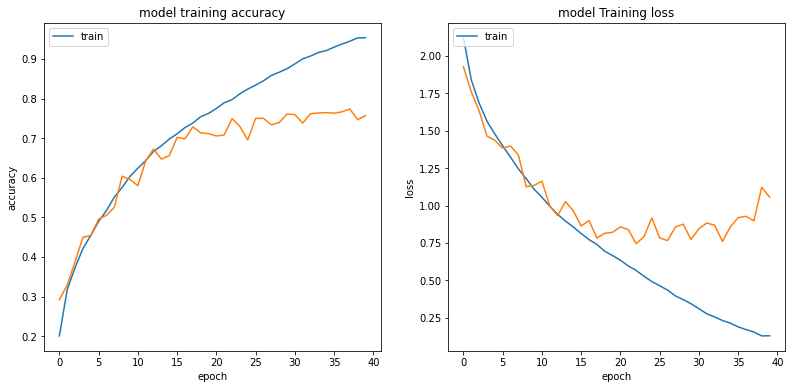

In [0]:
for growth in [6,12,24,36]:
  print("Growth rate is : ", growth)
  mydenseModel = denseModel((32, 32, 3), 5,64,3,1,[6,12,12], growth, 2,12)
  mydenseModel.compile(optimizer=tf.optimizers.SGD( learning_rate=0.01, momentum=0.8),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
  history = mydenseModel.fit(train_images, train_labels,batch_size=64, epochs=40, validation_split = 0.1 , verbose=0)
  print("Training accuray : {}, and validation accuracy :{}".format(round(history.history["accuracy"][-1]*100),round(history.history["val_accuracy"][-1]*100)))
  test_loss, test_acc = mydenseModel.evaluate(test_images,  test_labels, verbose=2)
  print('Final test accuracy : ', round(test_acc*100))

# summarize history for final run of the experiment
plt.figure(figsize=(35,35))
plt.subplot(5,5,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.subplot(5,5,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## Observations:
* There is not much change even though the growth range increased from 12 to 36
* But with increased growth there is more overfitting in the model as the difference between training accuracy and validation accuracy increases.

## **Experiment 3:**
> #### Changing the kernel size of the first Conv2d layer of the network
we will be testing following configurations 3,5,7 for kernel size. So total of 3 rounds of training and testing are performed as part of this experiment. 

> Other parameters are--
* Bottleneck Theta = 1
* Growth rate = 12 (Experiment 2 outcome)
* Depth of dense blocks = [6,12,12] (Experiment 1 outcome)
* filter size in dense block = 2
* Final dense block depth  = 12
* Number of total dense blocks = 4

First Layer kernel size is  :  3
Training accuray : 88.72, and validation accuracy :74.86
Final test accuracy :  73.12
First Layer kernel size is  :  5
Training accuray : 88.79, and validation accuracy :74.96
Final test accuracy :  72.94
First Layer kernel size is  :  7
Training accuray : 87.85, and validation accuracy :71.6
Final test accuracy :  70.7


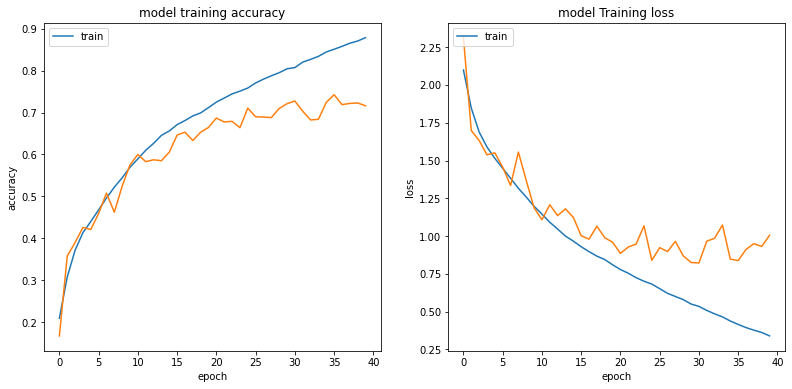

In [0]:
for f_size in [3,5,7]:
  print("First Layer kernel size is  : ", f_size)
  mydenseModel = denseModel((32, 32, 3), f_size,64,3,1,[6,12,12], 12, 2,12)
  mydenseModel.compile(optimizer=tf.optimizers.SGD( learning_rate=0.01, momentum=0.8),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
  history = mydenseModel.fit(train_images, train_labels,batch_size=64, epochs=40, validation_split = 0.1 , verbose=0)
  print("Training accuray : {}, and validation accuracy :{}".format(round(history.history["accuracy"][-1]*100,2),round(history.history["val_accuracy"][-1]*100,2)))
  test_loss, test_acc = mydenseModel.evaluate(test_images,  test_labels, verbose=0)
  print('Final test accuracy : ', round(test_acc*100,2))

# summarize history for final run of the experiment
plt.figure(figsize=(35,35))
plt.subplot(5,5,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.subplot(5,5,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## Observations:
* Validation accuracy with kernel size 3 and 5 are comparable (almost same)
* With increasing filter size of the first Conv2d layer, the test accuracy decreases.
* This supports the learning from the literature, i.e. usage of large filters in shallow(early) layers may impact adversely. The netwrok fails to learn appropriate filters for feature detection.

## **Experiment 4:**
> #### This is the last experiment to analyze the impact of compression in bottleneck layers.
we will be testing with compression 0.5 as part of this experiment. 

> Other parameters are--
* Bottleneck Theta = 0.5
* Growth rate = 12 (Experiment 2 outcome)
* Depth of dense blocks = [6,12,12] (Experiment 1 outcome)
* filter size in dense block = 2
* Final dense block depth  = 12
* Number of total dense blocks = 4
* First Layer kernel Size = 3(Experiment 3 outcome)

In [0]:
print("Compression is : ", 0.5)
mydenseModel = denseModel((32, 32, 3), 3,64,3,0.5,[6,12,12], 12, 2,12)
mydenseModel.compile(optimizer=tf.optimizers.SGD( learning_rate=0.01, momentum=0.8),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
history = mydenseModel.fit(train_images, train_labels,batch_size=64, epochs=40, validation_split = 0.1 , verbose=0)
print("Training accuray : {}, and validation accuracy :{}".format(round(history.history["accuracy"][-1]*100,2),round(history.history["val_accuracy"][-1]*100,2)))
test_loss, test_acc = mydenseModel.evaluate(test_images,  test_labels, verbose=0)
print('Final test accuracy : ', round(test_acc*100,2))

Compression is :  0.5
Training accuray : 86.96, and validation accuracy :73.32
Final test accuracy :  72.69


## Observations:
* Given the current model there is not much change in final test accuracy.
* Though it reduces merginally compared to testing with no compression setting.

In [0]:
print("Total number of layers in our model: ", len(mydenseModel.layers))
print ("#############################################")
mydenseModel.summary()

Total number of layers in our model:  116
#############################################
Model: "DenseNetModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1155 (Conv2D)            (None, 32, 32, 64)   1728        input_24[0][0]                   
__________________________________________________________________________________________________
activation_184 (Activation)     (None, 32, 32, 64)   0           conv2d_1155[0][0]                
__________________________________________________________________________________________________
max_pooling2d_23 (MaxPooling2D) (None, 16, 16, 64)   0           activation_184[0][0]            



---



---



# **Section II**
--- 
## Implementation of tf.function in custom training loop 
(For cookie challange)
> This section implements the tf.function with a custom training loop. We will use this on top of our above dense net model. The goal of this is to check whether we can achive faster speed of training with tf.function implementation. 

>  We performed two raining runs with the above model for 10 epochs once with the tf.function and once without. Finally we analyzed the outcome by looking at the time consumed by the two training runs.

In [0]:
import time
start = time.time()
mydenseModel = denseModel((32, 32, 3), 3,64,3,1,[6,12,12], 12, 2,12)
mydenseModel.compile(optimizer=tf.optimizers.SGD( learning_rate=0.01, momentum=0.8),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
history = mydenseModel.fit(train_images, train_labels,batch_size=64, epochs=10, validation_split = 0.1)
stop = time.time()
print("Total time taken to execute 5 epochs : {} seconds".format(stop -start))
print("###################")

Epoch 1/10
704/704 [==============================] - 17s 24ms/step - loss: 2.1365 - accuracy: 0.1977 - val_loss: 2.3642 - val_accuracy: 0.1770
Epoch 2/10
704/704 [==============================] - 17s 24ms/step - loss: 1.8892 - accuracy: 0.3028 - val_loss: 1.8205 - val_accuracy: 0.3184
Epoch 3/10
704/704 [==============================] - 17s 24ms/step - loss: 1.7238 - accuracy: 0.3608 - val_loss: 1.6406 - val_accuracy: 0.3834
Epoch 4/10
704/704 [==============================] - 17s 24ms/step - loss: 1.5989 - accuracy: 0.4065 - val_loss: 1.5402 - val_accuracy: 0.4300
Epoch 5/10
704/704 [==============================] - 17s 24ms/step - loss: 1.5071 - accuracy: 0.4431 - val_loss: 1.6030 - val_accuracy: 0.4190
Epoch 6/10
704/704 [==============================] - 17s 24ms/step - loss: 1.4203 - accuracy: 0.4769 - val_loss: 1.4871 - val_accuracy: 0.4434
Epoch 7/10
704/704 [==============================] - 17s 24ms/step - loss: 1.3300 - accuracy: 0.5152 - val_loss: 1.3748 - val_accuracy:

In [0]:
opt = tf.optimizers.SGD(learning_rate=0.01, momentum=0.8)
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=False)
train_acc_metric = tf.metrics.SparseCategoricalAccuracy()

mydenseModel = denseModel((32, 32, 3), 3,64,3,1,[6,12,12], 12, 2,12)

@tf.function
def train_step(imgs, lbls):
    with tf.GradientTape() as tape:
        logits = mydenseModel(imgs)
        xent = loss_fn(lbls, logits)

    varis = mydenseModel.trainable_variables
    grads = tape.gradient(xent, varis)
    opt.apply_gradients(zip(grads, varis))

    return xent, logits
data = tf.data.Dataset.from_tensor_slices(
    (train_images, train_labels))
data = data.shuffle(buffer_size=50000).batch(64)

start = time.time()
for epochs in range(1,11):
  for step, (img_batch, lbl_batch) in enumerate(data):
    xent, logits = train_step(img_batch, lbl_batch)
  train_acc_metric(lbl_batch, logits)
  acc = train_acc_metric.result()
  print("Final bathc traing Loss: {} Accuracy: {}".format(xent, acc))
  train_acc_metric.reset_states()

stop = time.time()
print("Total time taken to execute 5 epochs : {} seconds".format(stop-start))
print("###################")

Final bathc traing Loss: 1.9154462814331055 Accuracy: 0.4375
Final bathc traing Loss: 1.8430898189544678 Accuracy: 0.375
Final bathc traing Loss: 1.7002382278442383 Accuracy: 0.375
Final bathc traing Loss: 1.7983945608139038 Accuracy: 0.3125
Final bathc traing Loss: 1.800080418586731 Accuracy: 0.375
Final bathc traing Loss: 1.303182601928711 Accuracy: 0.5625
Final bathc traing Loss: 1.2030304670333862 Accuracy: 0.4375
Final bathc traing Loss: 1.125425934791565 Accuracy: 0.5
Final bathc traing Loss: 1.1267257928848267 Accuracy: 0.625
Final bathc traing Loss: 1.02139413356781 Accuracy: 0.6875
Total time taken to execute 5 epochs : 167.33144617080688 seconds
###################


## Observations: 
* Implementation of tf.function makes the training loop a bit faster. 
* even with 10 epochs there is a benefir of 5 seconds, i.e. the later method took 5 seconds less time to complete training. 


---



---



---

